In [ ]:
#Name Rayyan Ahsan
phone 03267477148
Intern ID: ARCH-2506-0238

ARIMA Forecasting for Ethereum

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Step 2: Load Historical Ethereum Data (ETH-USD)
data = yf.download('ETH-USD', start='2020-01-01', end='2024-12-31')
eth_df = data[['Close']]
eth_df.dropna(inplace=True)
eth_df = eth_df.asfreq('D')
eth_df = eth_df.fillna(method='ffill')
eth_df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,ETH-USD
Date,
2020-01-01,130.802002
2020-01-02,127.410179
2020-01-03,134.171707
2020-01-04,135.069366
2020-01-05,136.276779


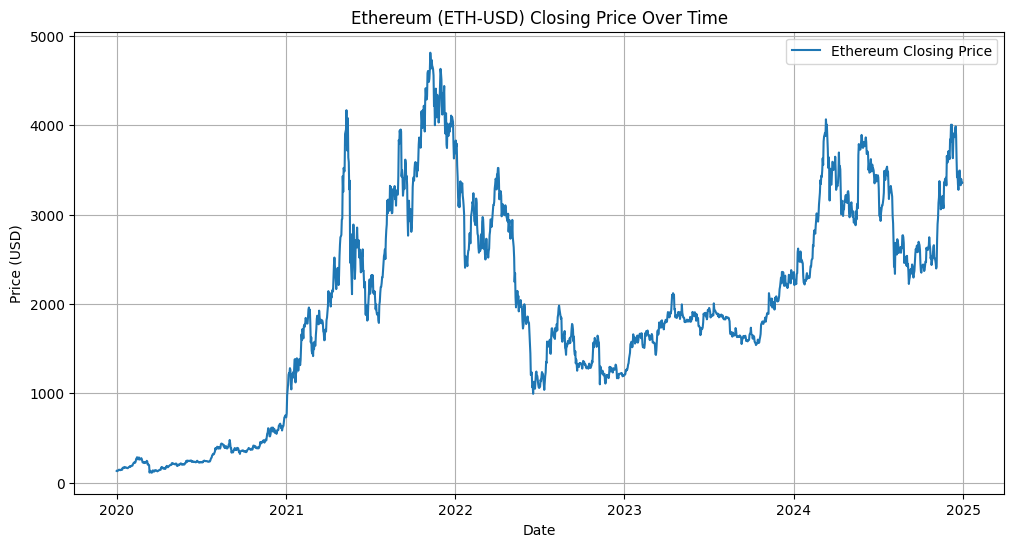

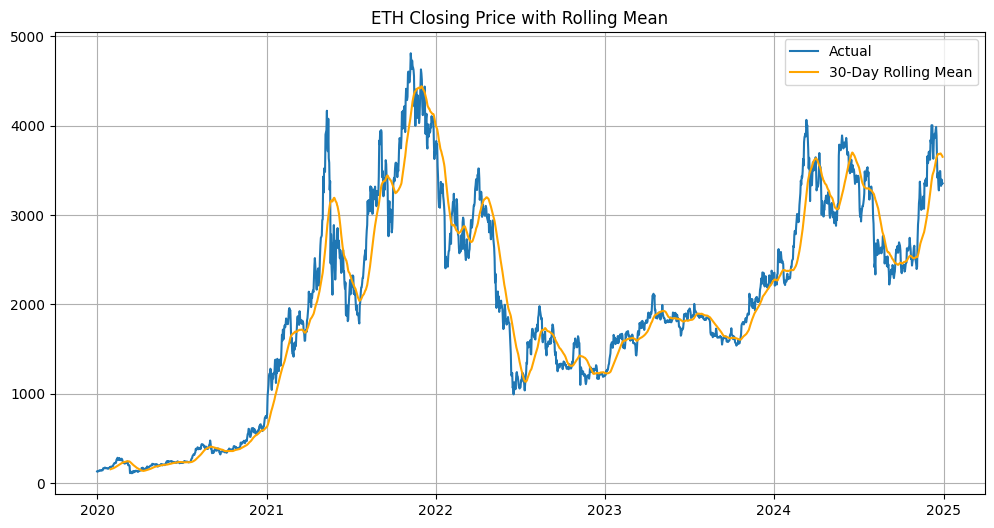

In [3]:
# Step 3: Exploratory Data Analysis
plt.figure(figsize=(12, 6))
plt.plot(eth_df, label='Ethereum Closing Price')
plt.title('Ethereum (ETH-USD) Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

eth_df['Rolling Mean'] = eth_df['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(eth_df['Close'], label='Actual')
plt.plot(eth_df['Rolling Mean'], label='30-Day Rolling Mean', color='orange')
plt.legend()
plt.title('ETH Closing Price with Rolling Mean')
plt.grid()
plt.show()


In [4]:
# Step 4: Stationarity Check - ADF Test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("✅ Data is stationary.")
    else:
        print("❌ Data is not stationary. Differencing is required.")

adf_test(eth_df['Close'])


ADF Statistic: -1.9388719525648033
p-value: 0.31400116530566735
❌ Data is not stationary. Differencing is required.


In [5]:
# Step 5: Differencing (if needed) and Recheck
eth_df['Close_diff'] = eth_df['Close'].diff().dropna()
eth_df.dropna(inplace=True)
adf_test(eth_df['Close_diff'])


ADF Statistic: -16.594952089879282
p-value: 1.7852774777215775e-29
✅ Data is stationary.


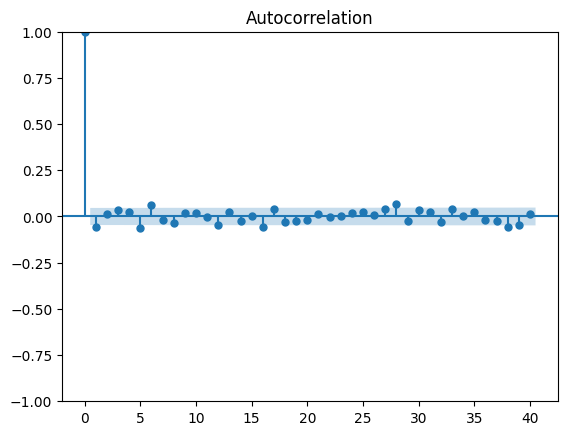

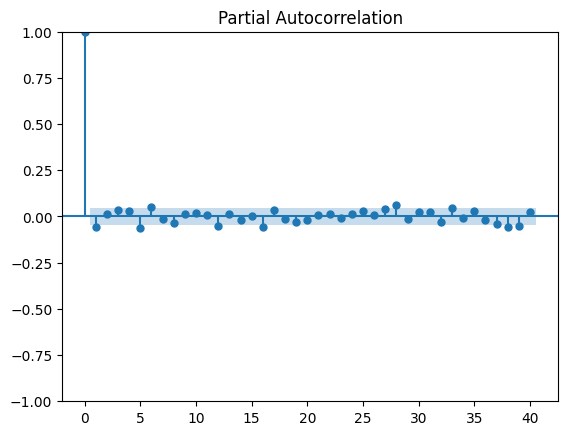

In [6]:
# Step 6: ACF and PACF Plots
plot_acf(eth_df['Close_diff'], lags=40)
plt.show()

plot_pacf(eth_df['Close_diff'], lags=40)
plt.show()


In [7]:
# Step 7: Fit ARIMA Model (manually try p,d,q or use auto_arima for automated approach)
model = ARIMA(eth_df['Close'], order=(5, 1, 2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                ETH-USD   No. Observations:                 1797
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -10692.302
Date:                Sat, 21 Jun 2025   AIC                          21400.605
Time:                        08:12:05   BIC                          21444.551
Sample:                    01-30-2020   HQIC                         21416.829
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8153      0.215     -3.796      0.000      -1.236      -0.394
ar.L2         -0.4297      0.172     -2.500      0.012      -0.767      -0.093
ar.L3          0.0283      0.025      1.154      0.2

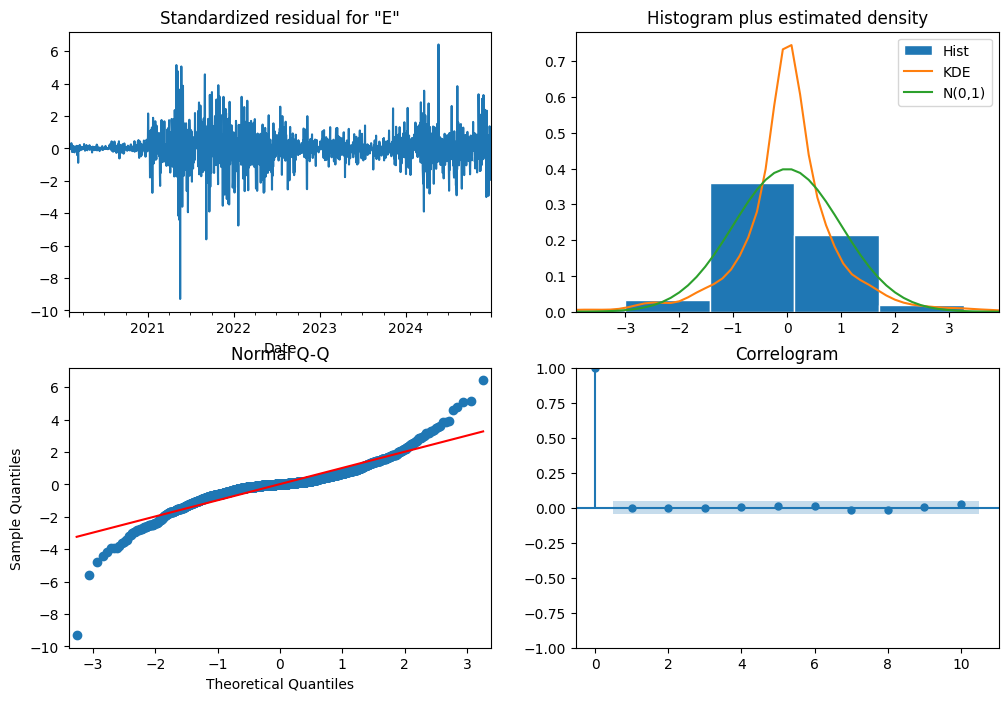

In [8]:
# Step 8: Model Diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


                               SARIMAX Results                                
Dep. Variable:                ETH-USD   No. Observations:                 1797
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -10692.302
Date:                Sat, 21 Jun 2025   AIC                          21400.605
Time:                        08:12:58   BIC                          21444.551
Sample:                    01-30-2020   HQIC                         21416.829
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8153      0.215     -3.796      0.000      -1.236      -0.394
ar.L2         -0.4297      0.172     -2.500      0.012      -0.767      -0.093
ar.L3          0.0283      0.025      1.154      0.2

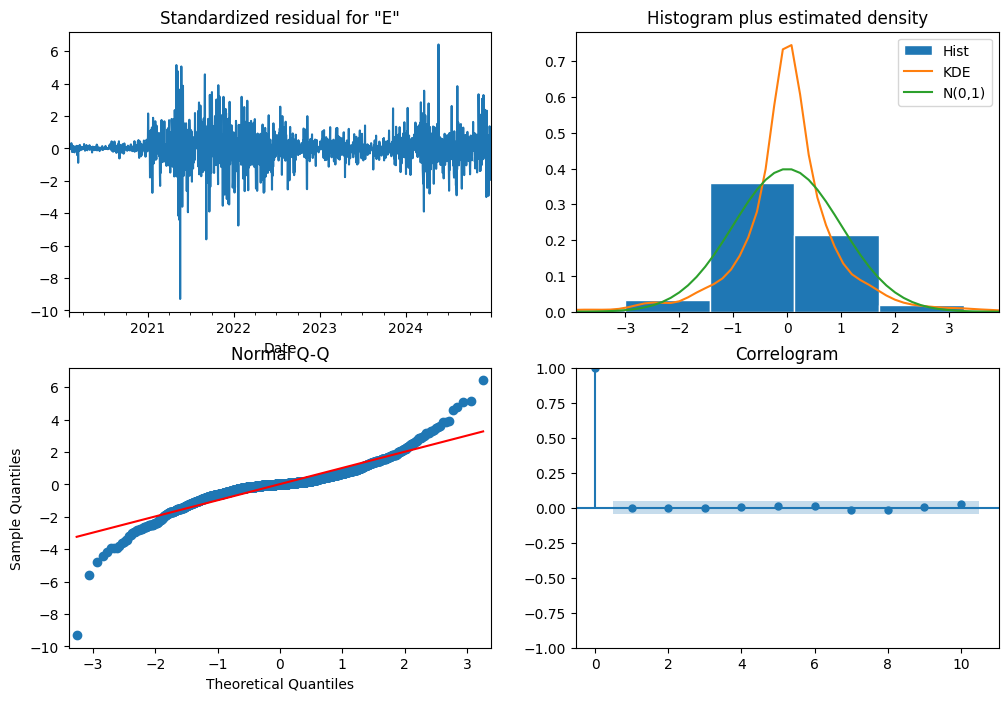

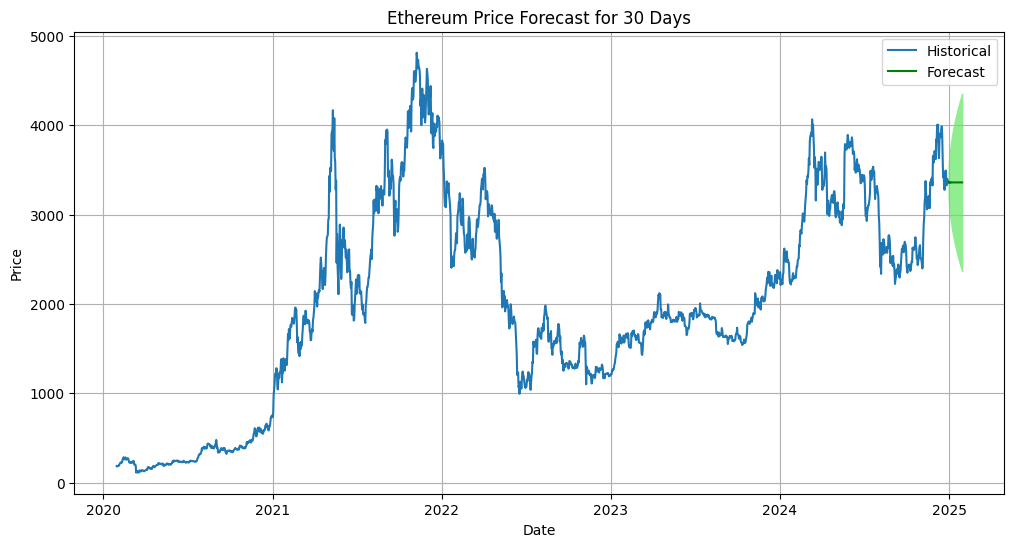

In [10]:
# Step 7: Fit ARIMA Model (manually try p,d,q or use auto_arima for automated approach)
model = ARIMA(eth_df['Close'], order=(5, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

# %%
# Step 8: Model Diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

# %%
# Step 9: Forecast Future Values
# Generate the forecast for the next 30 days
forecast = model_fit.get_forecast(steps=30)

# Get the mean forecast and confidence intervals
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    'mean': mean_forecast,
    'mean_ci_lower': conf_int.iloc[:, 0],
    'mean_ci_upper': conf_int.iloc[:, 1]
})

# %%
# Step 10: Visualization of Forecast
plt.figure(figsize=(12, 6))
plt.plot(eth_df['Close'], label='Historical')
plt.plot(forecast_df['mean'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='lightgreen')
plt.title('Ethereum Price Forecast for 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Step 11: Evaluation (using backtesting)
train = eth_df['Close'][:-30]
test = eth_df['Close'][-30:]
model_bt = ARIMA(train, order=(5, 1, 2)).fit()
preds = model_bt.forecast(steps=30)

rmse = np.sqrt(mean_squared_error(test, preds))
mape = mean_absolute_percentage_error(test, preds)

print("✅ RMSE:", rmse)
print("✅ MAPE:", mape)


✅ RMSE: 248.73960602047225
✅ MAPE: 0.06159345620574087


<Figure size 1200x600 with 0 Axes>

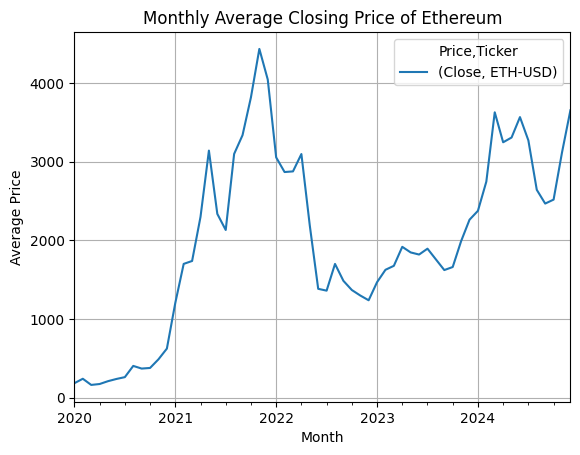

In [12]:
# Monthly average plot
eth_df['Month'] = eth_df.index.to_period('M')
monthly_avg = eth_df.groupby('Month')['Close'].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot()
plt.title('Monthly Average Closing Price of Ethereum')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()


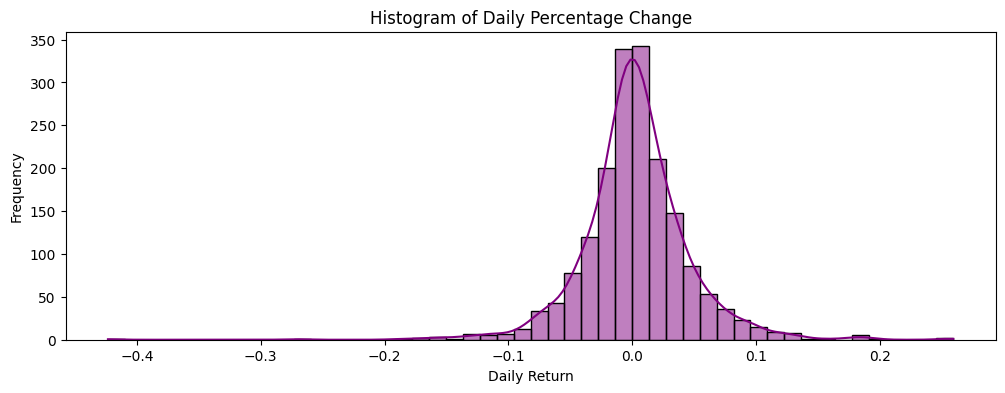

In [13]:
eth_df['Daily Change'] = eth_df['Close'].pct_change()
plt.figure(figsize=(12, 4))
sns.histplot(eth_df['Daily Change'].dropna(), bins=50, kde=True, color='purple')
plt.title('Histogram of Daily Percentage Change')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


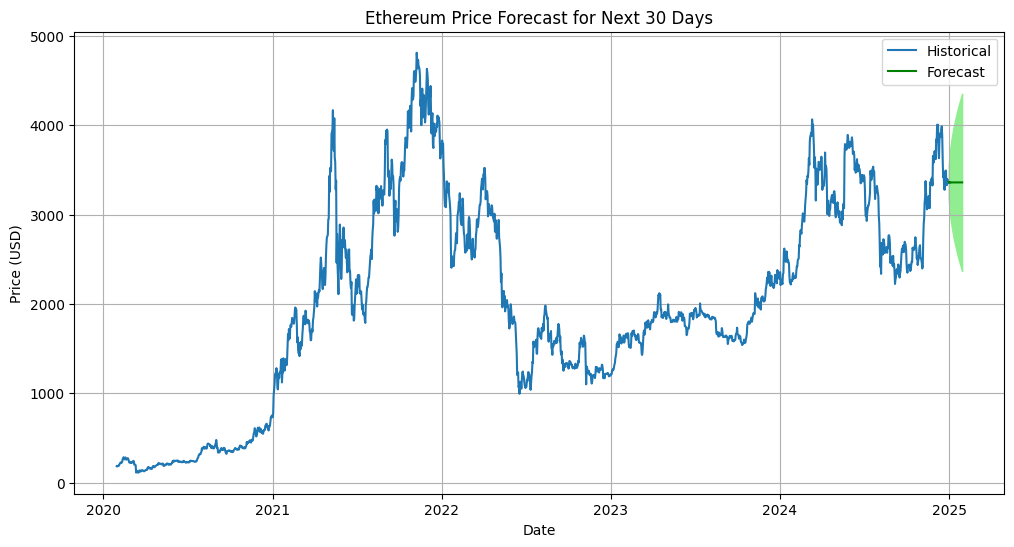

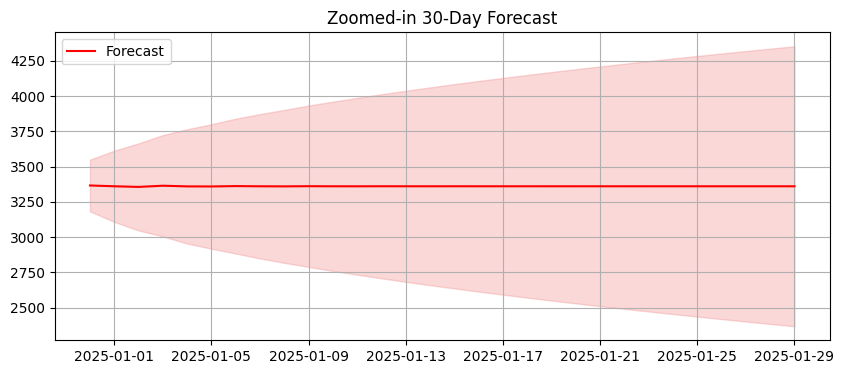

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(eth_df['Close'], label='Historical')
plt.plot(forecast_df['mean'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='lightgreen')
plt.title('Ethereum Price Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='lightcoral', alpha=0.3)
plt.title('Zoomed-in 30-Day Forecast')
plt.grid(True)
plt.legend()
plt.show()